This project aims to predict weather using data from 1960-2022 collected at a station in Oakland International Airport in California.

In [44]:
# Import modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt 
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor

# Reading in the initial data
weather = pd.read_csv("local_weather.csv", index_col="DATE")

## Data Exploration & Preparation

In [2]:
weather.head()

,STATION,NAME,ACMH,ACSH,AWND,DAPR,FMTM,FRGT,MDPR,PGTM,...,WT01,WT02,WT03,WT04,WT05,WT07,WT08,WT09,WT16,WT18
DATE,,,,,,,,,,,,,,,,,,,,,
1960-01-01,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-02,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
1960-01-03,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-04,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1960-01-05,USW00023230,"OAKLAND INTERNATIONAL AIRPORT, CA US",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN


We see that row indexes are dates, lets double check that it's a date time object so it's easier to work with. If not, lets convert it to one.

In [3]:
print(weather.index.dtype) # check data type
weather.index = pd.to_datetime(weather.index)


object


From a quick look at our dataset it seems we have data from Jan. 1, 1960 to Jan. 28, 2022. However there are a lot of missing values in a lot of the columns. Lets look at how much of each column is actually missing. 

In [4]:
# calculate % missing for each column 
round(weather.isnull().sum()/weather.shape[0]*100, 2)

STATION     0.00
NAME        0.00
ACMH       65.34
ACSH       65.34
AWND       52.25
DAPR       99.95
FMTM       87.01
FRGT       99.99
MDPR       99.95
PGTM       49.51
PRCP        1.67
SNOW       32.50
SNWD       31.76
TAVG       87.92
TMAX        0.05
TMIN        0.06
TSUN       93.17
WDF1       65.34
WDF2       52.24
WDF5       52.76
WDFG       74.69
WSF1       65.34
WSF2       52.23
WSF5       52.76
WSFG       74.69
WT01       77.99
WT02       98.02
WT03       99.29
WT04       99.98
WT05       99.83
WT07       99.99
WT08       81.04
WT09       99.99
WT16       88.40
WT18       99.98
dtype: float64

There seems to be large amounts of missingness in our data, with several columns such >90% null values. Looking at the documentation of this dataset, there are 5 core measurements:
* PRCP: amount of precipitation 
* TMAX: maximum temperature
* TMIN: minimum temperature
* SNOW: snowfall
* SNWD: snowfall depth 

For this project, we will only look at the core measurements listed. From above, we can see that PRCP, TMAX and TMIN have a very low proportion of missing values. However missingness is fairly high at 30% for SNOW and SNWD. Lets select these core columns and explore them further.

In [5]:
# Select the desired columns
core_cols = ['PRCP', 'TMAX', 'TMIN', 'SNOW', 'SNWD']
core_weather = weather[core_cols].copy()
core_weather.head()

,PRCP,TMAX,TMIN,SNOW,SNWD
DATE,,,,,
1960-01-01,0.0,49.0,30.0,0.0,0.0
1960-01-02,0.0,49.0,29.0,0.0,0.0
1960-01-03,0.0,54.0,35.0,0.0,0.0
1960-01-04,0.0,54.0,36.0,0.0,0.0
1960-01-05,0.0,55.0,33.0,0.0,0.0


In [6]:
# Look at SNOW column 
core_weather['SNOW'].value_counts()

0.0    11379
1.0        1
Name: SNOW, dtype: int64

It seems that from all our data, snow has only been recorded one time. Since this will not provide our model with much if any information, we will remove SNOW from our analysis. Given that SNWD is the depth of snow, it is also likely to contain no information in an area without regular snowfall and will also be removed.

In [7]:
# quick check of SNWD
core_weather['SNWD'].value_counts()

0.0    11504
Name: SNWD, dtype: int64

In [8]:
# remove SNOW and SNWD 
core_weather = core_weather.drop(["SNOW", "SNWD"], axis = 1, errors = 'ignore')
core_weather.head(2) # check it worked

,PRCP,TMAX,TMIN
DATE,,,
1960-01-01,0.0,49.0,30.0
1960-01-02,0.0,49.0,29.0


Now lets examine the PRCP, TMAX, and TMIN columns further.

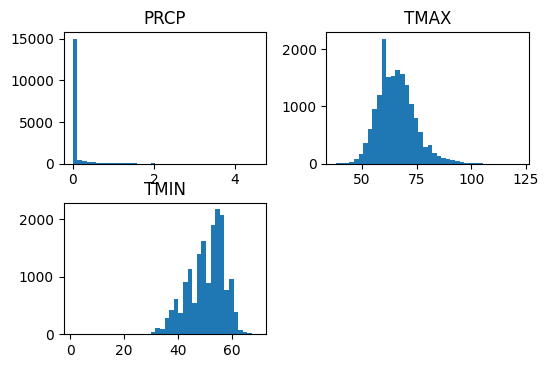

In [9]:
# histogram of prcp and tmax, tmin columns
%matplotlib inline

core_weather.hist(bins=40, grid = False)
plt.show()

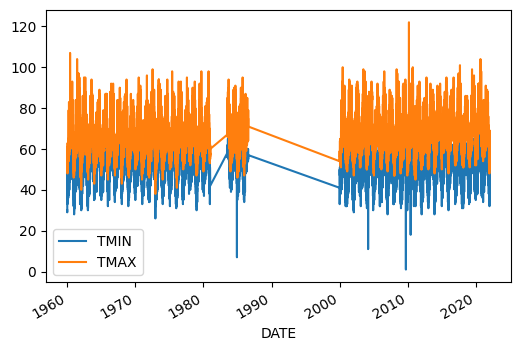

In [10]:
core_weather[["TMIN", "TMAX"]].plot()

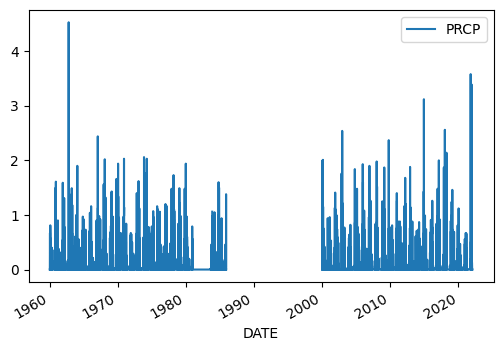

In [11]:
core_weather[["PRCP"]].plot()

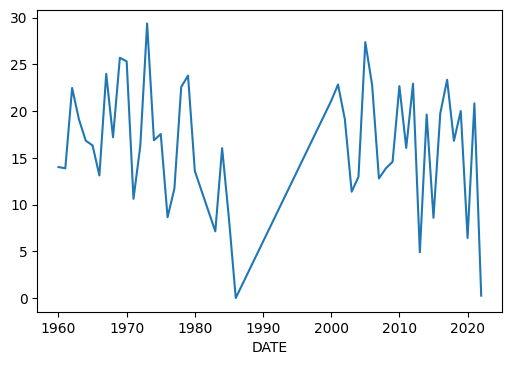

In [12]:
core_weather.groupby(by = core_weather.index.year).sum()["PRCP"].plot()

From the histrograms we can see that there is no precipitation on majority of the days. Due to this and the low amount of missingness in this column, we will use simple imputation with the mode (0). To impute the maximum and minimum temperatures, we will take an average of the previous day and next day with available information as temperatures tend to be similar with consecutive days. The missingness in these columns are also very small.

When plotting the maximum and minimum temperatures a big chunk of data is missing from before the 1990s until the 2000s, and a chunk in the 1980s. After looking at the documentation of the data on the National Oceanic and Atmospheric Administration website, there seems to be no running network during these periods of time (1981 - 1983 and 1986 - 2000).  

In [13]:
core_weather.index.year.value_counts().sort_index()

1960    366
1961    365
1962    365
1963    365
1964    366
1965    365
1966    365
1967    365
1968    366
1969    365
1970    365
1971    365
1972    366
1973    365
1974    365
1975    365
1976    366
1977    365
1978    365
1979    365
1980    366
1983    184
1984    366
1985    365
1986    212
2000    365
2001    365
2002    365
2003    365
2004    366
2005    365
2006    365
2007    365
2008    366
2009    365
2010    365
2011    365
2012    365
2013    365
2014    365
2015    365
2016    366
2017    365
2018    365
2019    365
2020    366
2021    364
2022     28
Name: DATE, dtype: int64

Looking at the value counts in each year, we see that periods with missing networks corresponds to the gaps in our data. For the purpose of this project, we will work with the gaps. 

However we also observe some outliers from the plots, with temperatures reaching a maximum of about 120F and minimum of almost 0F. According to google, the lowest temperature Oakland has ever experienced was 25F in 1949, and the highest was 104F so these values are likely data errors. We will remove anything lower than 20 and higher than 110 then impute these points with the rest of the missing values. 

In [14]:
core_weather.loc[core_weather["TMAX"] > 110, "TMAX"] = np.nan
core_weather.loc[core_weather["TMIN"] < 20,  "TMIN"] = np.nan

In [15]:
# Impute PRCP with mode of 0 
core_weather["PRCP"].fillna(0, inplace=True)

# Impute TMAX with mean from one day before and one day after 
core_weather["TMAX"] = core_weather["TMAX"].interpolate()

# Impute TMIN with mean from one day before and one day after 
core_weather["TMIN"] = core_weather["TMIN"].interpolate()

core_weather.isna().sum() # check for missing values 

PRCP    0
TMAX    0
TMIN    0
dtype: int64

Now that we filled in the missing values, lets ensure all our columns are of the correct type. 

In [16]:
core_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 16859 entries, 1960-01-01 to 2022-01-28
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   PRCP    16859 non-null  float64
 1   TMAX    16859 non-null  float64
 2   TMIN    16859 non-null  float64
dtypes: float64(3)
memory usage: 526.8 KB


All of our columns are floats, which is appropriate. 

## Model Fitting

Now that our data is cleaned and ready for modeling, we will start preparing the target column (maximum temperature for the next day) then split the data into training and testing sets.

In [17]:
# Create target column - next rows max temp 
core_weather['target'] = core_weather.shift(-1)["TMAX"]
core_weather = core_weather.iloc[:-1,] # remove last row - no target

core_weather.tail() # Check

,PRCP,TMAX,TMIN,target
DATE,,,,
2022-01-23,0.0,60.0,41.0,60.0
2022-01-24,0.0,60.0,39.0,57.0
2022-01-25,0.0,57.0,43.0,57.0
2022-01-26,0.0,57.0,41.0,67.0
2022-01-27,0.0,67.0,39.0,64.0


We are going to create a function that splits the test and train sets, fits the model, generate predictions and calculates an error metric to allow us to evaluate our model. 

Note that when we split our data into training and testing sets, we do not randomly order the rows because do not want to use future information to predict the past. 

In [18]:
def rr(predictors, target, df):
    #* predictors: array of column names
    #* target: string of target column name
    #* df: dataframe object 
    
    # Spliting training and testing sets 
    train = df[:"2020-12-31"]
    test = df["2021-01-01":]
    
    rr = Ridge()
    rr.fit(train[predictors], train[target])
    predictions = rr.predict(test[predictors])
    mse = mean_squared_error(predictions, test[target])
    rmse = mse**(1/2)
    
    df_predictions = pd.DataFrame({'observed': test[target], 'predicted': predictions}, 
                                  columns=['observed', 'predicted'])
    df_predictions.index = test.index
    
    return(predictions, mse, rmse, df_predictions)

In [19]:
pred_vars = ["TMAX", "TMIN", "PRCP"]

predictions, mse, rmse, df_predictions = rr(pred_vars, "target", core_weather)

print(mse)
print(rmse)

20.562813962242505
4.534623905269599


In [20]:
df_predictions.head()

,observed,predicted
DATE,,
2021-01-01,57.0,59.780838
2021-01-02,56.0,59.288154
2021-01-03,62.0,58.508856
2021-01-04,59.0,61.525770
2021-01-05,59.0,59.417769


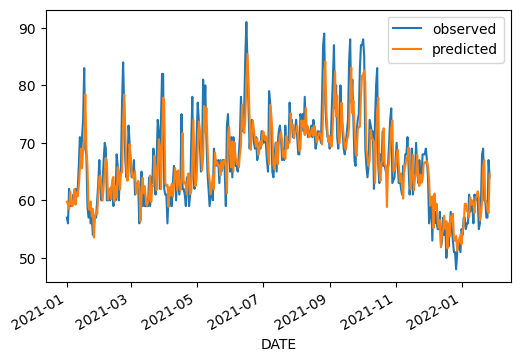

In [21]:
df_predictions.plot()

On average, our model was 4.5F away from the observed temperatures. It was able to predict the next day temperatures fairly accurately from the plot but seems to be slightly less extreme than the observed values. 

Lets try improving this model through additional predictors:

    1. 30 day moving average in maximum temperature
    2. Ratio between 30 day average and the daily maximum temperature
    3. Ratio between daily maximum and minimum temperature 

In [22]:
# 30 day moving average temperature 
core_weather["TMAX_30avg"] = core_weather.rolling(30, axis = 0).mean()["TMAX"]

# Ratio b/w 30 day average and daily maximum (how different they are)
core_weather["TMAX_vs_30avg"] = core_weather["TMAX_30avg"]/core_weather["TMAX"]

# Ratio between maxmimum temperature and minimum temperature
core_weather["TMAX_vs_TMIN"] = core_weather["TMAX"]/core_weather["TMIN"]

core_weather2 = core_weather.iloc[29:] # remove first 30 rows due to NaNs from moving avg

In [23]:
core_weather2.head()

,PRCP,TMAX,TMIN,target,TMAX_30avg,TMAX_vs_30avg,TMAX_vs_TMIN
DATE,,,,,,,
1960-01-30,0.00,61.0,49.0,59.0,55.233333,0.905464,1.244898
1960-01-31,0.00,59.0,46.0,62.0,55.566667,0.941808,1.282609
1960-02-01,0.81,62.0,51.0,59.0,56.000000,0.903226,1.215686
1960-02-02,0.00,59.0,43.0,59.0,56.166667,0.951977,1.372093
1960-02-03,0.20,59.0,47.0,60.0,56.333333,0.954802,1.255319


In [24]:
# rerun model with new predictors
pred_vars2 = ["TMAX", "TMIN", "PRCP", "TMAX_30avg", "TMAX_vs_30avg", "TMAX_vs_TMIN"]

predictions2, mse2, rmse2, df_predictions2 = rr(pred_vars2, "target", core_weather2)

print(mse2)
print(rmse2)

20.00146411994179
4.472299645589704


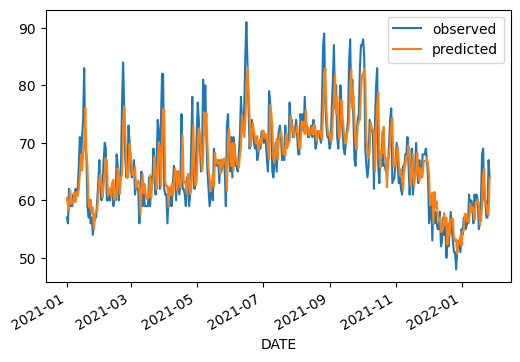

In [25]:
df_predictions2.plot()

Looking at the RMSE, there is a slight increase in accuracy as on average model 2 is only 4.47F off from the observed, while the first model was 4.53F off. However, a difference of .06F on average is very minimal.

From the plot it seems that our second model tends to make predictions that are less extreme than that first. 

Lets see if adding average monthly temperatures and average daily temperatures from previous years improves our predictions.

In [30]:
 %%capture [--no-]
core_weather2["TAVG_month"] = core_weather2["TMAX"].groupby(core_weather2.index.month).apply(lambda x: x.expanding(1).mean())
core_weather2["TAVG_day"] = core_weather2["TMAX"].groupby([core_weather2.index.month, core_weather2.index.day]).apply(lambda x: x.expanding(1).mean())

In [31]:
# Run and evaluate model 3 
pred_vars3 = pred_vars2 + ["TAVG_month", "TAVG_day"]

predictions3, mse3, rmse3, df_predictions3 = rr(pred_vars3, "target", core_weather2)

print(mse3)
print(rmse3)

19.350723590267823
4.3989457362267865


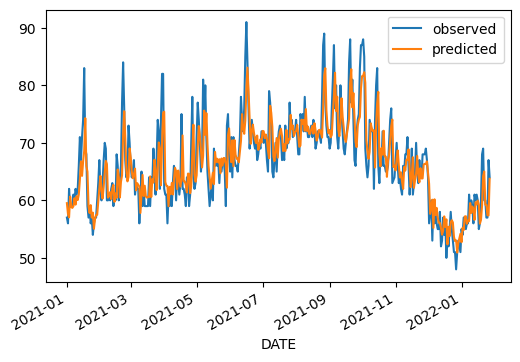

In [32]:
df_predictions3.plot()

This third model with additional variables performs better than the previous two, with a lower RMSE of ~4.40F compared to 4.47F from the second model and 4.53F from the first. 

## Regression Trees
Lets compare our error from the ridge regression model to another machine learning method: regression trees. We will refit the model using the latest set of predictor variables and generate MSE and RMSE estimates, and plot the predictions to evaluate performance.

In [53]:
def rtree(predictors, target, df):
    #* predictors: array of column names
    #* target: string of target column name
    #* df: dataframe object 
    
    # Spliting training and testing sets 
    train = df[:"2020-12-31"]
    test = df["2021-01-01":]
    
    rtree = DecisionTreeRegressor()
    rtree.fit(train[predictors], train[target])
    predictions = rtree.predict(test[predictors])
    mse = mean_squared_error(predictions, test[target])
    rmse = mse**(1/2)
    
    df_predictions = pd.DataFrame({'observed': test[target], 'predicted': predictions}, 
                                  columns=['observed', 'predicted'])
    df_predictions.index = test.index
    
    return(predictions, mse, rmse, df_predictions)


In [54]:
p_tree, mse_tree, rmse_tree, df_p_tree = rtree(pred_vars3, "target", core_weather2)

print(mse_tree)
print(rmse_tree)

45.09271099744245
6.715110646701397


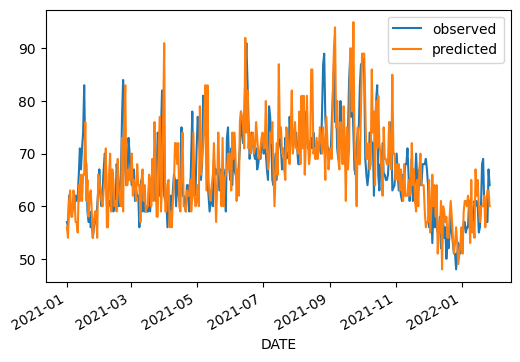

In [55]:
df_p_tree.plot()

The predictions from regression trees were less accurate, even compared to the simplest ridge regression model. It produced a RMSE of 6.72F off from the observed on average. 